# Example of buidling and training a neural net with a NN class

### Dr. Tirthajyoti Sarkar<br><br>Fremont, CA 94536 <br><br>Nov 2019

In PyTorch, often a neural network model is built as a user-defined class (where layers are stacked one of top another) using a base class called `nn.Module`. We show an example of how to build and train a neural network with such a class object. 

In [1]:
from torch import nn
import torch

In [2]:
# Checking if GPU compute is available for your training
torch.cuda.is_available()

True

### Input features and data

In [3]:
from sklearn.datasets import make_classification
import numpy as np
import matplotlib.pyplot as plt

In [4]:
input_dim = 5
data_points = 100

In [5]:
X, y = make_classification(data_points, input_dim, n_informative=3, random_state=101)
X = X.astype(np.float32)
y = y.astype(np.float32)

### Visualizing the dataset

In [6]:
from itertools import combinations
comb_list = list(combinations([v for v in range(5)],2))

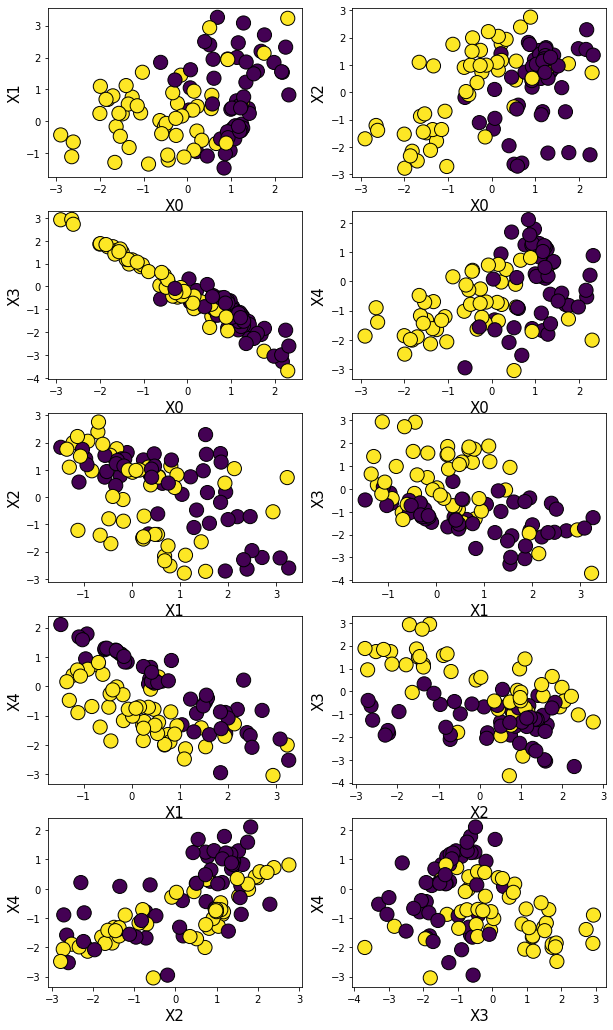

In [7]:
fig, ax  = plt.subplots(5,2,figsize=(10,18))
axes = ax.ravel()
for i,c in enumerate(comb_list):
    j,k = c
    axes[i].scatter(X[:,j],X[:,k],c=y,edgecolor='k',s=200)
    axes[i].set_xlabel("X"+str(j),fontsize=15)
    axes[i].set_ylabel("X"+str(k),fontsize=15)
plt.show()

### Converting to PYTorch tensors

In [8]:
X = torch.from_numpy(X)
y = torch.from_numpy(y)

In [9]:
X.shape

torch.Size([100, 5])

### Network parameters

Set your network architecture parameters here. We will work with just two hidden layers for this demo. The input layer dimension must match the dimension of the input feature vector ___X___. The output dimension is just one, this being a simple binary classification problem.

![NN model](https://raw.githubusercontent.com/tirthajyoti/PyTorch_Machine_Learning/master/images/NN-2.PNG)

In [10]:
n_input = X.shape[1] # Must match the shape of the input features
n_hidden1 = 8 # Number of neurons in the 1st hidden layer
n_hidden2 = 4 # Number of neurons in the 2nd hidden layer
n_output = 1 # Number of output units (for example 1 for binary classification)

### Define the class `Network` using the `nn.Module` base class
In PyTorch, the custom is to define your own neural net class, as a super class inherited from the base class `nn.Module`. This way, full power of the Object-Oriented-Programming (OOP) can be maintained while working with neural net models.

In [11]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        # Inputs to the 1st hidden layer linear transformation
        self.hidden1 = nn.Linear(n_input,n_hidden1)
        # Inputs to the 2nd hidden layer linear transformation
        self.hidden2 = nn.Linear(n_hidden1,n_hidden2)
        # Activation function for the hidden layers' output - ReLU
        self.relu = nn.ReLU()
        # Output layer linear transformation
        self.output = nn.Linear(n_hidden2, n_output)
        # Activation function for the output layer - sigmoid
        self.sigmoid = nn.Sigmoid()

    def forward(self, X, **kwargs):
        # Passes the input tensor through each of the defined operations
        X = self.hidden1(X)
        X = self.relu(X)
        X = self.hidden2(X)
        X = self.relu(X)
        X = self.output(X)
        X = self.sigmoid(X)
        return X

### Initiate and print the model

In [12]:
model = Network()

In [13]:
print(model)

Network(
  (hidden1): Linear(in_features=5, out_features=8, bias=True)
  (hidden2): Linear(in_features=8, out_features=4, bias=True)
  (relu): ReLU()
  (output): Linear(in_features=4, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


### Loss function
Choosing proper loss function is an important step in the task of training a neural network. Here, we choose the Binary cross-entropy loss with the `nn.BCELoss()` method.

In [14]:
criterion = nn.BCELoss() # Binary cross-entropy loss

### Compute output probabilities with the untrained model
Let us run the input dataset through the neural net model we have defined i.e. forward pass once and compute the output probabilities. As the weights have been initialized as random, we will see random output probabilities (mostly close to 0.5). This network has not been trained yet.

In [15]:
logits = model.forward(X) # Output of the forward pass (logits i.e. probabilities)

In [16]:
print("First 10 probabilities...\n",logits[:10])

First 10 probabilities...
 tensor([[0.5926],
        [0.5854],
        [0.5369],
        [0.5802],
        [0.5905],
        [0.6010],
        [0.5723],
        [0.5842],
        [0.5971],
        [0.5883]], grad_fn=<SliceBackward>)


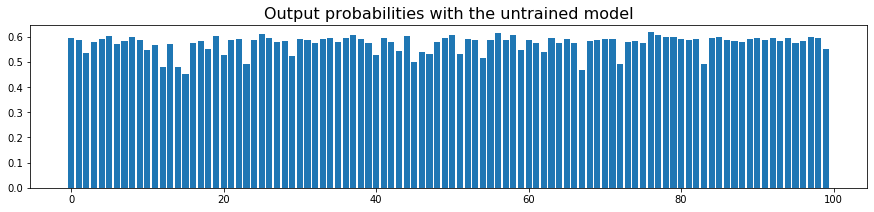

In [17]:
logits_numpy = model.forward(X).detach().numpy().flatten()
plt.figure(figsize=(15,3))
plt.title("Output probabilities with the untrained model",fontsize=16)
plt.bar([i for i in range(100)],height=logits_numpy)
plt.show()

### Compute mean loss with these output probabilities
After computing the output of the neural net model, we can simply pass on those values to the loss function along with the ground truth, to compute the total loss.

While training, we will do this computation over and over again.

In [18]:
loss = criterion(logits,y)

c:\users\tirth\docume~1\personal\datasc~2\python~1\tf-gpu\lib\site-packages\torch\nn\modules\loss.py:498: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


In [19]:
print(loss.item())

0.707131028175354


### Gradients of the weights of the network
PyTorch has the awesome functionality called [Autograd (i.e. automatic differentiation)](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html), which keeps track of and computes the gradient (derivative) of all the tensors used in a neural net. We can turn-off this feature in certain cases, but by default the gradient information is preserved (`.require_grad=True`) as the tensors flow through the network. This way, backward gradient.can be computed using the chain rule, which is at the heart of the [backpropagation algorithm](http://neuralnetworksanddeeplearning.com/chap2.html).

However, to calculate the gradient we need to execute `tensor.backward()` method. Below we show, how we get `None` when we try to print the gradients of the 2nd hidden layer weights. But after executing `loss.backward()` we get the computed gradients alright.

In [20]:
print("Gradients of the weights of the 2nd hidden layer connections before computing gradient:\n",model.hidden2.weight.grad)
loss.backward() # Compute gradients
print("Gradients of the weights of the 2nd hidden layer connections after computing gradient:\n",model.hidden2.weight.grad)

Gradients of the weights of the 2nd hidden layer connections before computing gradient:
 None
Gradients of the weights of the 2nd hidden layer connections after computing gradient:
 tensor([[ 0.0239, -0.0320,  0.0115, -0.0022, -0.0118,  0.0037,  0.0089, -0.0047],
        [ 0.0076, -0.0059,  0.0238, -0.0196, -0.0051, -0.0018,  0.0022,  0.0049],
        [-0.0115,  0.0111, -0.0145,  0.0098,  0.0004,  0.0005, -0.0035, -0.0056],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]])


### Optimizer
Optimizer is the module which drives the loss towards a minimum following a specific mathematical algorithm. Here, we choose the simple Stochastic Gradient Descent (SGD) optimizer with a learning rate of 0.1.

In [21]:
from torch import optim

In [22]:
optimizer = optim.SGD(model.parameters(),lr=0.1)

### Forward and backward propagation one step
Now, we show how to do forward and backward passes with one step of optimizer. This set of code can be found at the heart of any PyTorch neural net model.

In [23]:
optimizer.zero_grad() # Resets the gradients i.e. do not accumulate over passes

# Forward pass
output = model.forward(X)

# Initial weights
init_weights = model.hidden2.weight
print("Initial weights:\n",model.hidden2.weight)

# Calculate loss
loss = criterion(output,y)

# Backward pass (AutoGrad)
loss.backward()
grads = model.hidden2.weight.grad
print("Gradient:\n",model.hidden2.weight.grad)

# One step of the optimizer
optimizer.step()

# Update the weights
updated_weights = model.hidden2.weight
print("Updated weights:\n",model.hidden2.weight)

Initial weights:
 Parameter containing:
tensor([[ 0.2535,  0.3130, -0.2713, -0.1814,  0.3448,  0.3373,  0.2821, -0.1791],
        [-0.1212, -0.2878,  0.2879,  0.1565, -0.1669, -0.3110, -0.2456,  0.1226],
        [ 0.3273, -0.0469,  0.0854,  0.2370, -0.0876,  0.3385,  0.2827,  0.0705],
        [-0.0047,  0.1919,  0.1442,  0.1528, -0.1964,  0.1652, -0.2572, -0.0771]],
       requires_grad=True)
Gradient:
 tensor([[ 0.0239, -0.0320,  0.0115, -0.0022, -0.0118,  0.0037,  0.0089, -0.0047],
        [ 0.0076, -0.0059,  0.0238, -0.0196, -0.0051, -0.0018,  0.0022,  0.0049],
        [-0.0115,  0.0111, -0.0145,  0.0098,  0.0004,  0.0005, -0.0035, -0.0056],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]])
Updated weights:
 Parameter containing:
tensor([[ 0.2511,  0.3162, -0.2724, -0.1812,  0.3460,  0.3369,  0.2812, -0.1786],
        [-0.1220, -0.2872,  0.2855,  0.1585, -0.1664, -0.3109, -0.2458,  0.1221],
        [ 0.3284, -0.0480,  0.0869,  0.2360, -0.0877,  0.338

### Looping over multiple epochs
The essential mechanism of forward and backward passes have been showen above. This is essentially one epoch of training. For proper training, we just have tp repeat it over many epochs.

We will notice that losses go down with epochs.

In [24]:
epochs = 10
for i,e in enumerate(range(epochs)):
    # Reset the grads
    optimizer.zero_grad()
    # Forward pass
    output = model.forward(X)
    # Calculate loss
    loss = criterion(output.view(output.shape[0]),y)
    # Print loss
    print(f"Epoch - {i+1}, Loss - {round(loss.item(),3)}")
    # Backpropagation
    loss.backward()
    # Optimizer one step
    optimizer.step()

Epoch - 1, Loss - 0.705
Epoch - 2, Loss - 0.703
Epoch - 3, Loss - 0.702
Epoch - 4, Loss - 0.7
Epoch - 5, Loss - 0.698
Epoch - 6, Loss - 0.696
Epoch - 7, Loss - 0.694
Epoch - 8, Loss - 0.693
Epoch - 9, Loss - 0.691
Epoch - 10, Loss - 0.689


### Running for a large number of epochs for proper classification

In [25]:
epochs = 1000
running_loss = []
  
for i,e in enumerate(range(epochs)):
    optimizer.zero_grad()
    output = model.forward(X)
    loss = criterion(output,y)
    loss.backward()
    optimizer.step()
    running_loss.append(loss.item())

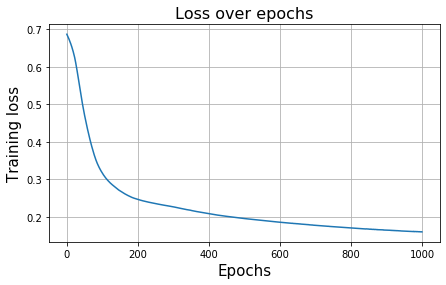

In [26]:
plt.figure(figsize=(7,4))
plt.title("Loss over epochs",fontsize=16)
plt.plot([e for e in range(epochs)],running_loss)
plt.grid(True)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Training loss",fontsize=15)
plt.show()

### How the predicted probabilities change over training

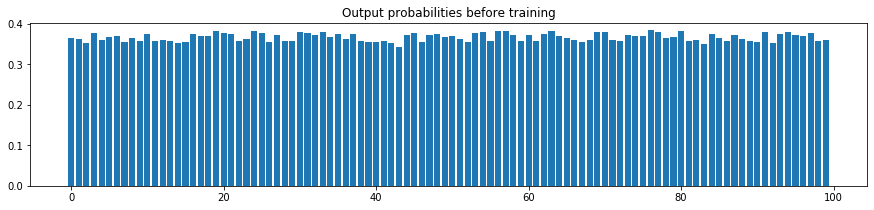

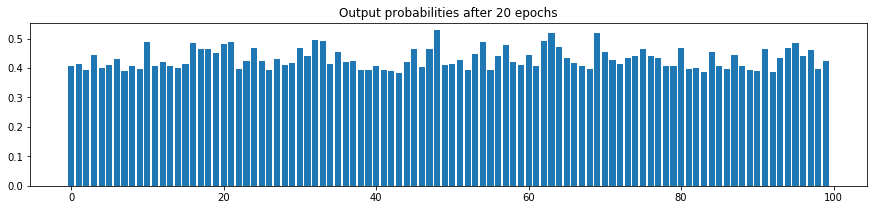

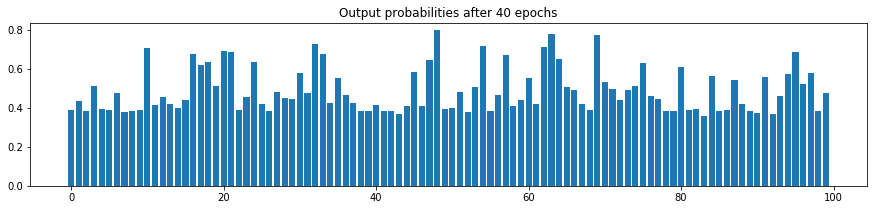

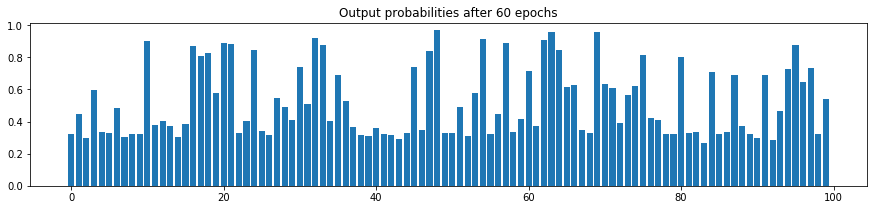

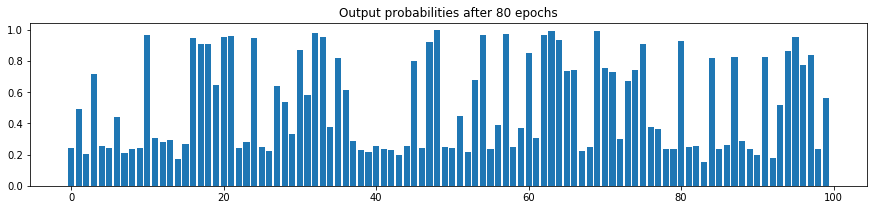

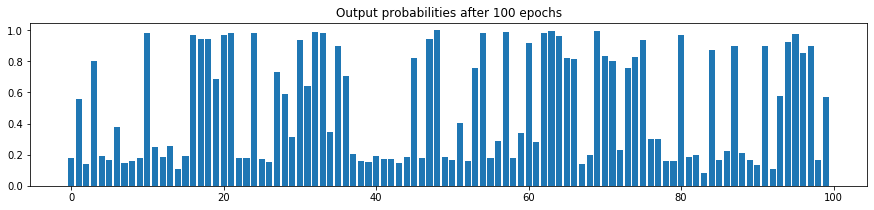

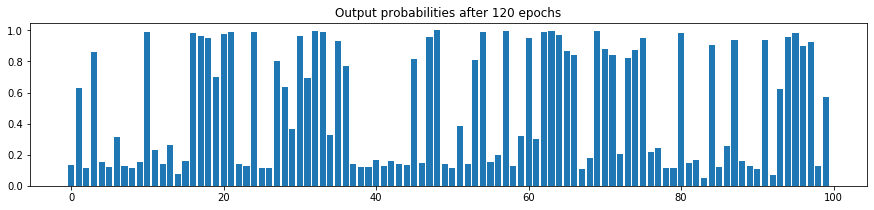

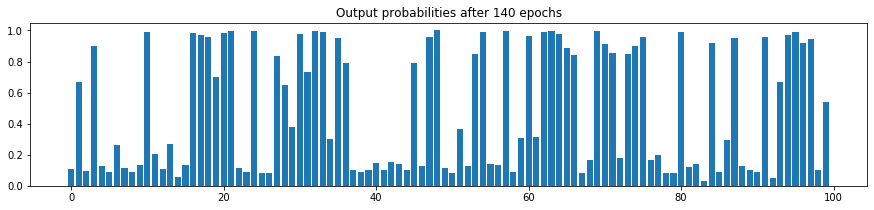

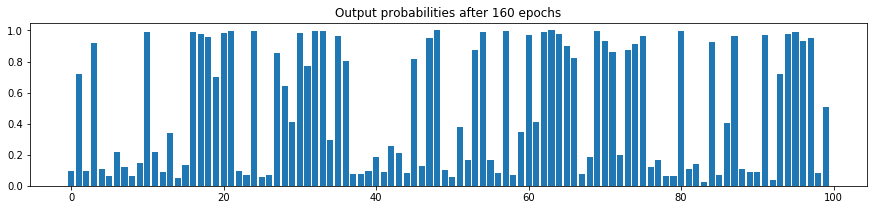

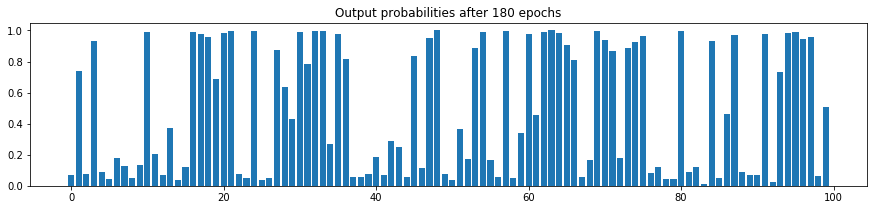

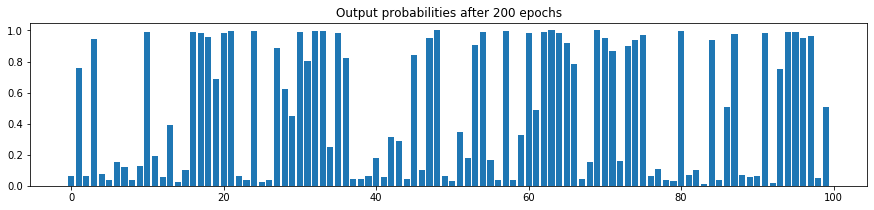

In [27]:
model = Network()
optimizer = optim.SGD(model.parameters(),lr=0.1)
epochs = 200
running_loss = []

logits = model.forward(X).detach().numpy().flatten()
plt.figure(figsize=(15,3))
plt.title("Output probabilities before training".format(i+1))
plt.bar([i for i in range(100)],height=logits)
plt.show()

for i,e in enumerate(range(epochs)):
    optimizer.zero_grad()
    output = model.forward(X)
    loss = criterion(output,y)
    loss.backward()
    optimizer.step()
    running_loss.append(loss.item())
    if i!=0 and (i+1)%20==0:
        logits = model.forward(X).detach().numpy().flatten()
        plt.figure(figsize=(15,3))
        plt.title("Output probabilities after {} epochs".format(i+1))
        plt.bar([i for i in range(100)],height=logits)
        plt.show()

### A training function

In [44]:
def train_NN(mod,X,y,opt,epochs=10,verbose=True):
    """
    Trains a given model for a specific number of epochs with the given data
    Arguments:
        mod: Neural net model
        X: Feature tensor
        y: Output tensor
        epochs: Number of epochs
        verbose: If True, prints out the loss function value
    """
    for i,e in enumerate(range(epochs)):
        # Reset the grads
        opt.zero_grad()
        # Forward pass
        output = mod.forward(X)
        # Calculate loss
        loss = criterion(output.view(output.shape[0]),y)
        # Print loss
        if verbose:
            print(f"Epoch - {i+1}, Loss - {round(loss.item(),3)}")
        # Backpropagation
        loss.backward()
        # Optimizer one step
        opt.step()
    return mod

In [62]:
new_model= Network()
optimizer = optim.SGD(new_model.parameters(),lr=0.04)
trained_model=train_NN(new_model,X,y,optimizer,epochs=800,verbose=False)

### A funky network

In [105]:
class FunkyNetwork(nn.Module):
    def __init__(self):
        super(FunkyNetwork, self).__init__()
        # Inputs to the 1st hidden layer linear transformation
        self.hidden1 = nn.Linear(n_input,n_hidden1)
        # Inputs to the 2nd hidden layer linear transformation
        self.hidden2 = nn.Linear(n_hidden1,n_hidden2)
        # Activation function for the hidden layers' output - ReLU
        self.relu = nn.ReLU()
        # Activation function for the hidden layers' output - hyperbolic tan
        self.tanh = nn.Tanh()
        # Output layer linear transformation
        self.output = nn.Linear(n_hidden2, n_output)
        # Activation function for the output layer - sigmoid
        self.sigmoid = nn.Sigmoid()

    def forward(self, X, **kwargs):
        X = self.hidden1(X)
         # Pass the output of the first hidden layer through two parallel activations
        X1 = self.relu(X)
        X2 = self.tanh(X)
        # Sum these two activation outputs
        X3 = (X1+X2)
        # Now pass it through the second hidden layer like normal
        X3 = self.hidden2(X3)
        X3 = self.relu(X3)
        X3 = self.output(X3)
        X3 = self.sigmoid(X3)
        return X3

In [114]:
new_model= FunkyNetwork()
optimizer = optim.SGD(new_model.parameters(),lr=0.04)
trained_model=train_NN(new_model,X,y,optimizer,epochs=100,verbose=False)
loss = criterion(trained_model(X).view(trained_model(X).shape[0]),y)
print(loss.item())

0.4840814471244812


In [115]:
new_model= Network()
optimizer = optim.SGD(new_model.parameters(),lr=0.04)
trained_model=train_NN(new_model,X,y,optimizer,epochs=100,verbose=False)
loss = criterion(trained_model(X).view(trained_model(X).shape[0]),y)
print(loss.item())

0.688626229763031
